In [1]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hits = []
for i in range(1, 7):
    hits.extend(json.load(open(f"/home/jpivarski/storage/data/physicists/acat-papers/acat-papers-{i}.json"))["hits"]["hits"])

In [3]:
acats = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
cnums = {
    "C90-03-19": 1,
    "C92-01-13.1": 2,
    "C94-04-21": 3,
    "C95-04-03": 4,
    "C96-09-02.4": 5,
    # "C99-04-12": ,
    "C00-10-16.1": 6,
    "C02-06-24.3": 7,
    "C03-12-01.2": 8,
    "C05-05-22": 9,
    "C07-04-23.1": 10,
    "C08-11-03.1": 11,
    "C10-02-22": 12,
    "C11-09-05.3": 13,
    "C13-05-16": 14,
    "C14-09-01.1": 15,
    "C16-01-18.1": 16,
    "C17-08-21": 17,
    "C19-03-11": 18,
    "C20-09-08": 19,
    # "C21-11-29": 19,
}
years = [
    "'90",
    "'92",
    "'93",
    "'95",
    "'96",
    # "'99",
    "'00",
    "'02",
    "'03",
    "'05",
    "'07",
    "'08",
    "'10",
    "'11",
    "'13",
    "'14",
    "'16",
    "'17",
    "'19",
    # "'21",
]

In [4]:
words = [
    r"analysis",
    r"simulation",
    r"reconstruction",
    r"trigger",
    r"(acquisition|\bDAQ\b)",
    r"(lattice|\bLQCD\b)",

    r"(machine[- ]learn|\bML\b)",
    r"(neural|\bNN\b)",
    r"deep[- ]learn",
    r"(boosted[- ]decision|\bBDT\b)",

    r"tool",
    r"framework",
    r"distributed",
    r"parallel",
    r"concurren",
    r"interactive",
    r"collaborative",
    r"preserv",
    r"query",

    r"FORTRAN",
    r"C\+\+",
    r"Java",
    r"Python",
    r"\bAda\b",
    r"Pascal",

    r"(object[- ]orient|\bOOP?\b)",
    r"array",
    r"(functional[- ](prog|analy|lang|style|query|archi|interf)|purely functional|\bFP\b)",
    r"declarative",

    r"database",
    r"(web|\bWWW\b)",
    r"(UNIX|Linux)",
    r"\bXML\b",
    r"\bJSON\b",

    r"\bROOT\b",
    r"\b(Objectivity|ORM|OODB(|MS))\b",
    r"\b(Hippoplotamus|HippoDraw)\b",
    r"\b(Java Analysis Studio|JAS|Jas4pp|FreeHEP)\b",
    r"\bPROOF\b",
    r"\b([RT]DataFrame|RDF)\b",
    r"\b(Uproot|Coffea|Scikit-HEP)\b",

    r"\bCPUs?\b",
    r"\b(GPUs?|CUDA)\b",
    r"\b(FPGAs?|V?HDL|Verilog)\b",
    r"\bTPUs?\b",
    r"\bRISCs?\b",
    
    r"columnar",
    r"\bLHC\+\+",
    r"Julia",
]

In [5]:
counters = {word: [0] * 18 for word in words}
pairs = [(word, re.compile(word, re.I)) if word != r"\bPROOF\b" else (word, re.compile(word)) for word in words]
denoms = [0] * 18

for hit in hits:
    cnum = None
    for pubinfo in hit["metadata"]["publication_info"]:
        cnum = pubinfo.get("cnum")
        if cnum in cnums:
            break
    if cnum in cnums:
        denoms[cnums[cnum] - 1] += 1
        for word, regex in pairs:
            in_title = any(regex.search(title["title"]) is not None for title in hit["metadata"].get("titles", []))
            in_abstract = any(regex.search(abstract["value"]) is not None for abstract in hit["metadata"].get("abstracts", []))
            if in_title or in_abstract:
                counters[word][cnums[cnum] - 1] += 1

In [6]:
def plot(which, counters, denoms, **special):
    index = pd.Index(acats, name="ACAT")
    df = pd.DataFrame({x if x != r"\bPROOF\b" else x + " (case-sensitive)": counters[x] for x in counters if x in which}, index=index)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

    df.div(0.01 * pd.Series(denoms, index=index), axis=0).plot(ax=ax, **special)
    ax.set_xlim(1, 19)
    ax.set_ylim(bottom=0)
    ax2 = ax.twiny()
    ax2.set_xticks([x - 1 for x in acats])
    ax2.set_xticklabels(years)
    ax2.set_xlabel("year")
    ax.set_xticks(acats)
    ax.set_xticklabels(acats)
    ax.set_ylabel("percent of talks with matching title/abstract")
    ax.set_xlabel("ACAT number")
    ax.tick_params(labelleft=True, labelright=True)
    
    return ax

In [7]:
plt.rcParams.update({"figure.facecolor": (1, 1, 1, 1)})

In [8]:
c1, c2, c3, c4, c5, c6, c7, c8, c9, c10 = plt.rcParams["axes.prop_cycle"].by_key()["color"]

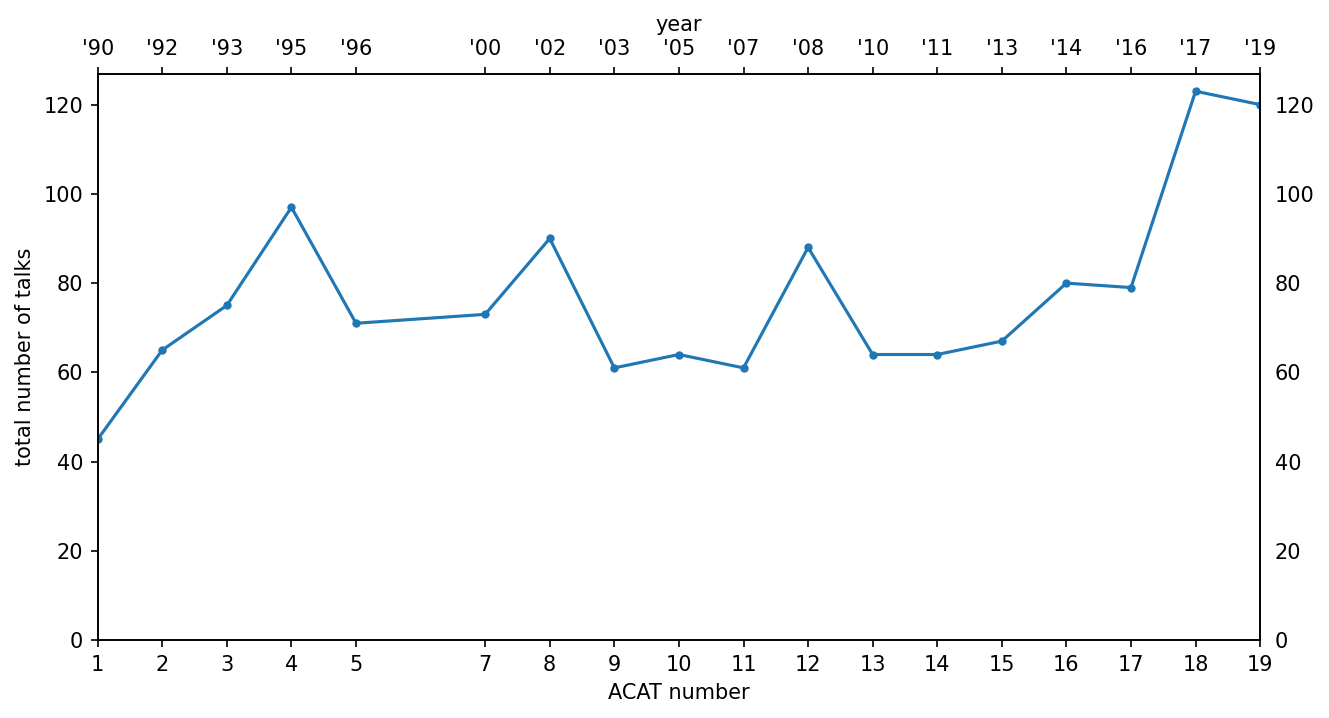

In [9]:
index = pd.Index(acats, name="ACAT")

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

pd.Series(denoms, index=index).plot(ax=ax, style=".-")
ax.set_xlim(1, 19)
ax.set_ylim(bottom=0)
ax2 = ax.twiny()
ax2.set_xticks([x - 1 for x in acats])
ax2.set_xticklabels(years)
ax2.set_xlabel("year")
ax.set_xticks(acats)
ax.set_xticklabels(acats)
ax.set_ylabel("total number of talks")
ax.set_xlabel("ACAT number")
ax.tick_params(labelleft=True, labelright=True)

plt.savefig("PLOTS/acat-papers-denominator.svg")
plt.savefig("PLOTS/acat-papers-denominator.pdf")

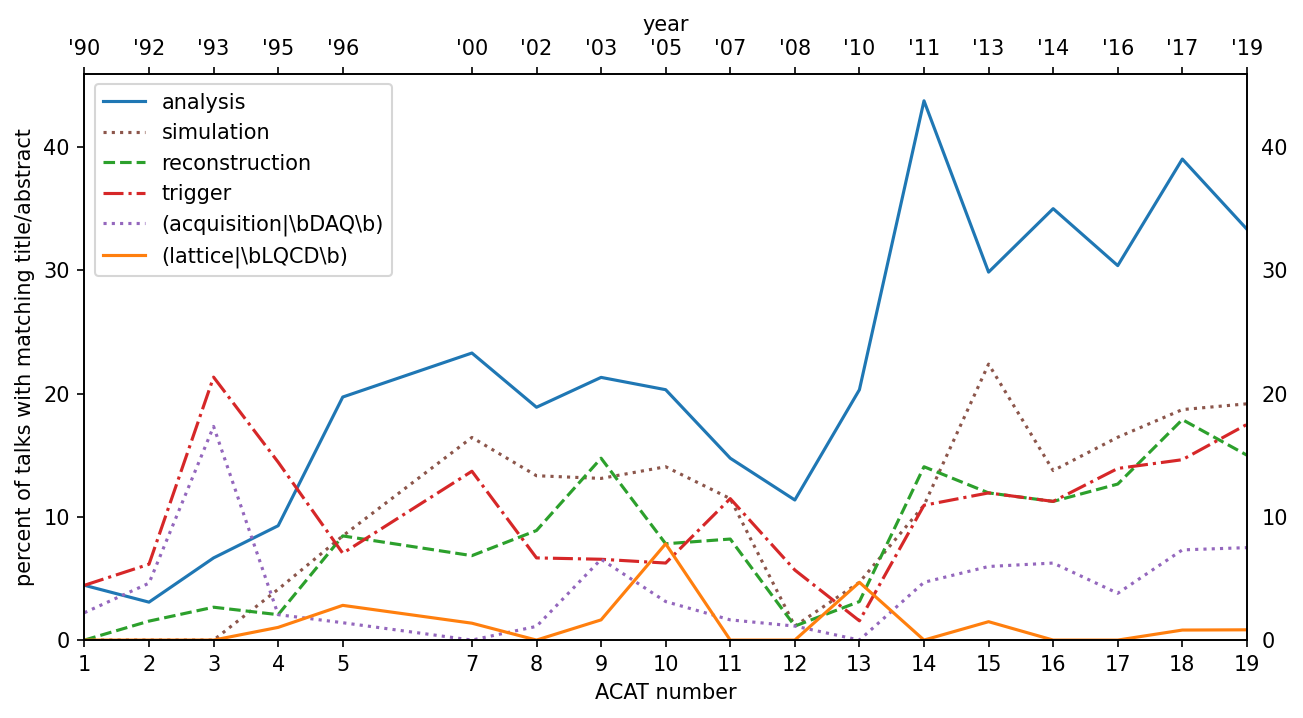

In [10]:
plot(words[0:6], counters, denoms, style=["-", ":", "--", "-.", ":", "-"], color=[c1, c6, c3, c4, c5, c2])
plt.savefig("PLOTS/acat-papers-task.svg")
plt.savefig("PLOTS/acat-papers-task.pdf")

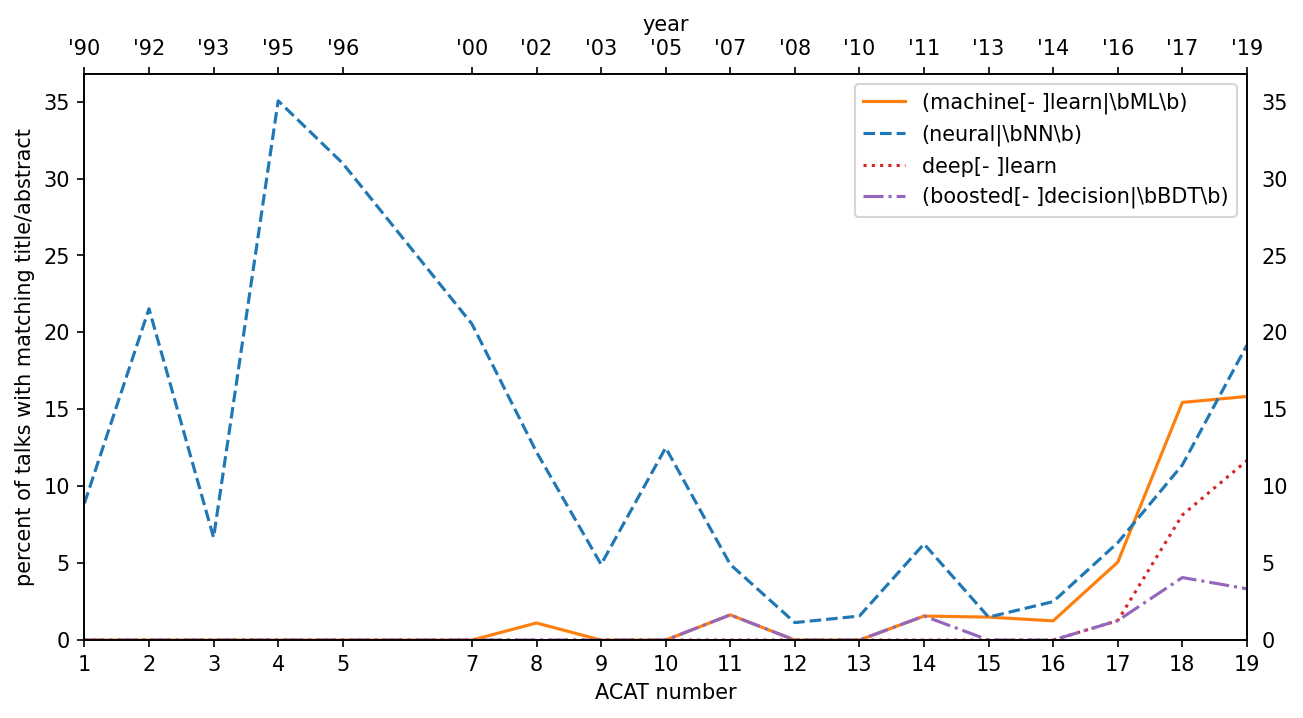

In [11]:
plot(words[6:10], counters, denoms, style=["-", "--", ":", "-.", "-"], color=[c2, c1, c4, c5, c3])
plt.savefig("PLOTS/acat-papers-ml.svg")
plt.savefig("PLOTS/acat-papers-ml.pdf")

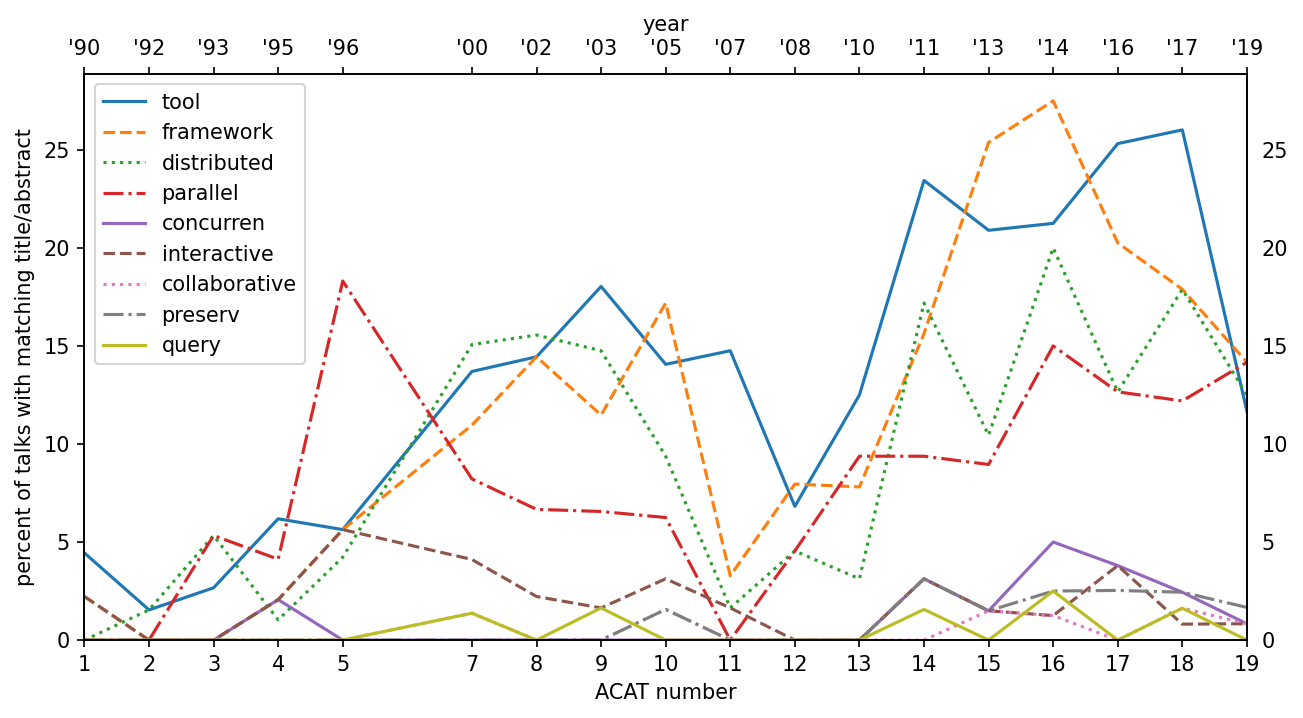

In [12]:
ax = plot(words[10:19], counters, denoms, style=["-", "--", ":", "-.", "-", "--", ":", "-.", "-"])
ax.legend(bbox_to_anchor=(0, 0, 0.6, 1))
plt.savefig("PLOTS/acat-papers-descriptor.svg")
plt.savefig("PLOTS/acat-papers-descriptor.pdf")

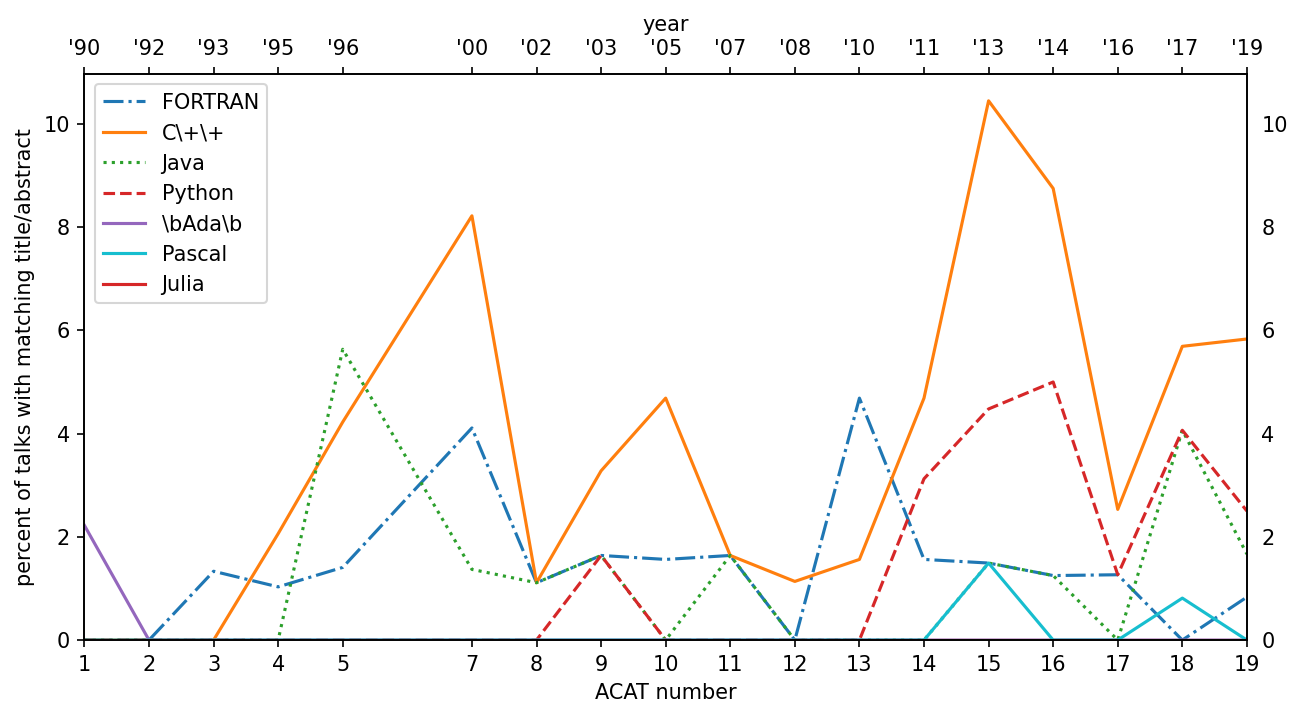

In [13]:
plot(words[19:25] + words[-1:], counters, denoms, style=["-.", "-", ":", "--", "-", "-", "-"], color=[c1, c2, c3, c4, c5, c10, c4])
plt.savefig("PLOTS/acat-papers-language.svg")
plt.savefig("PLOTS/acat-papers-language.pdf")

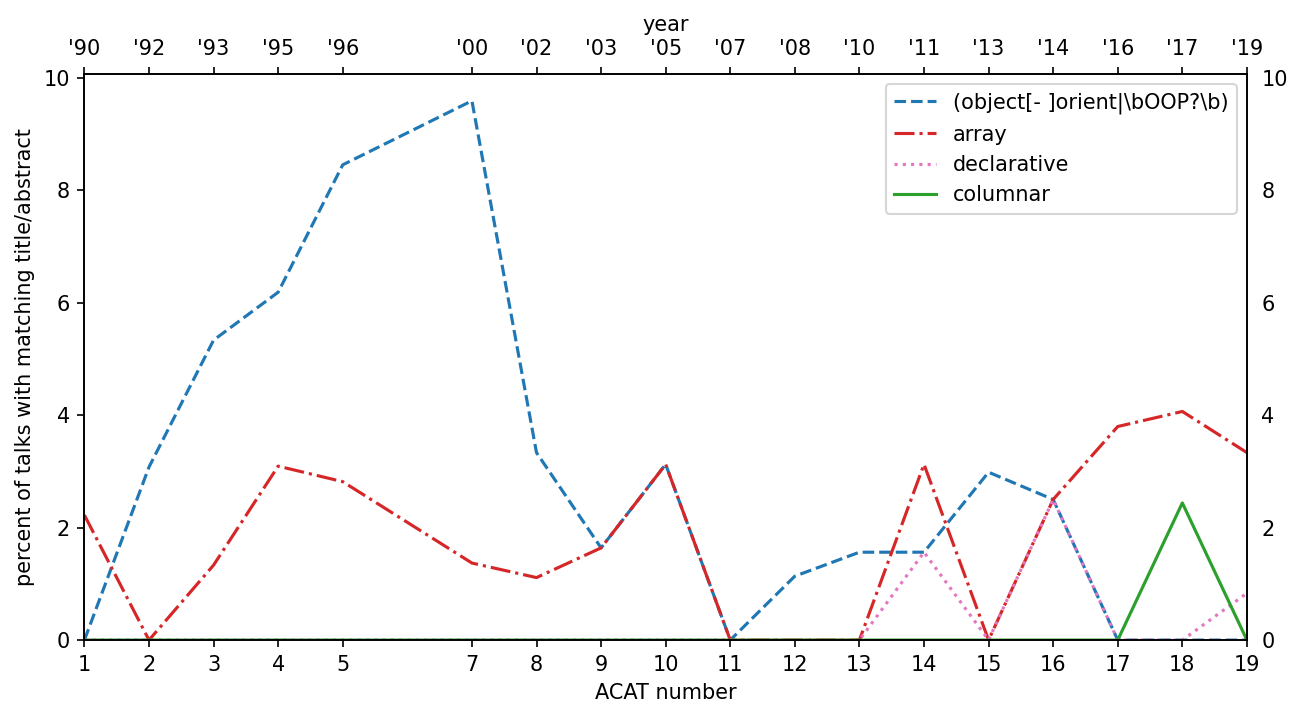

In [14]:
plot([words[25], words[26], words[28], words[-3]], counters, denoms, style=["--", "-.", ":", "-"], color=[c1, c4, c7, c3])
plt.savefig("PLOTS/acat-papers-paradigm.svg")
plt.savefig("PLOTS/acat-papers-paradigm.pdf")

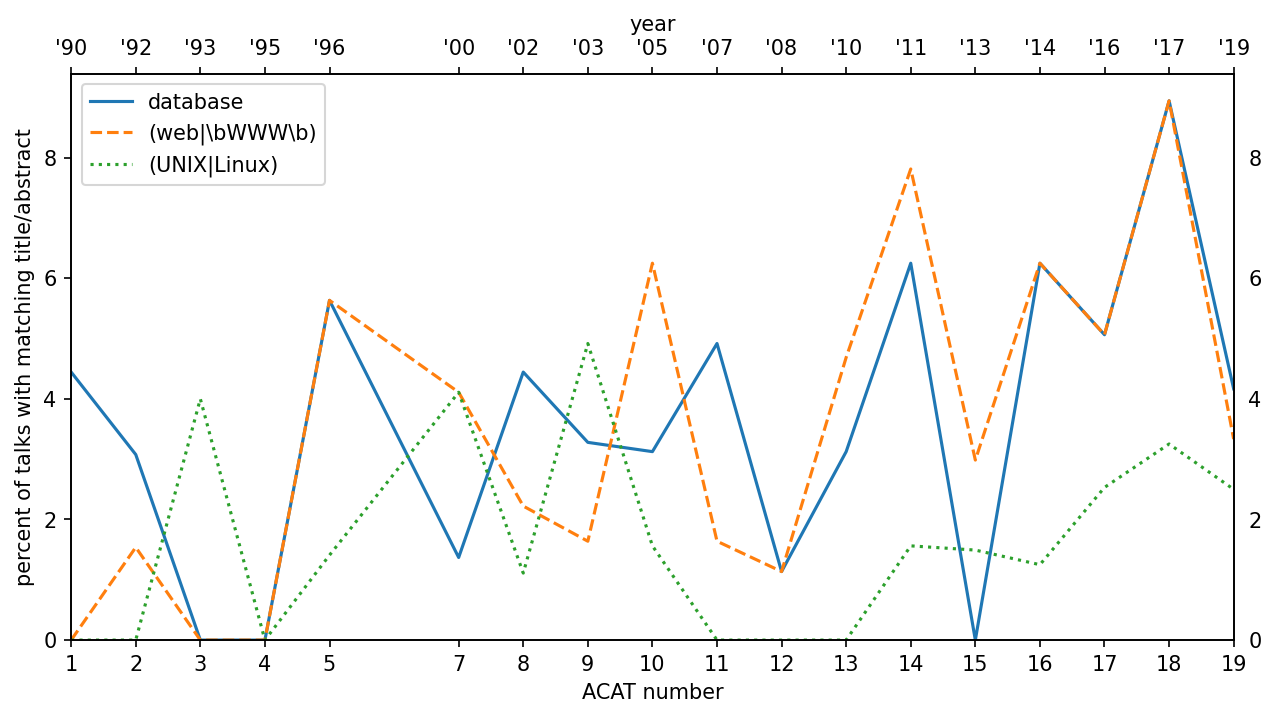

In [15]:
plot(words[29:32], counters, denoms, style=["-", "--", ":"], color=[c1, c2, c3])
plt.savefig("PLOTS/acat-papers-technology.svg")
plt.savefig("PLOTS/acat-papers-technology.pdf")

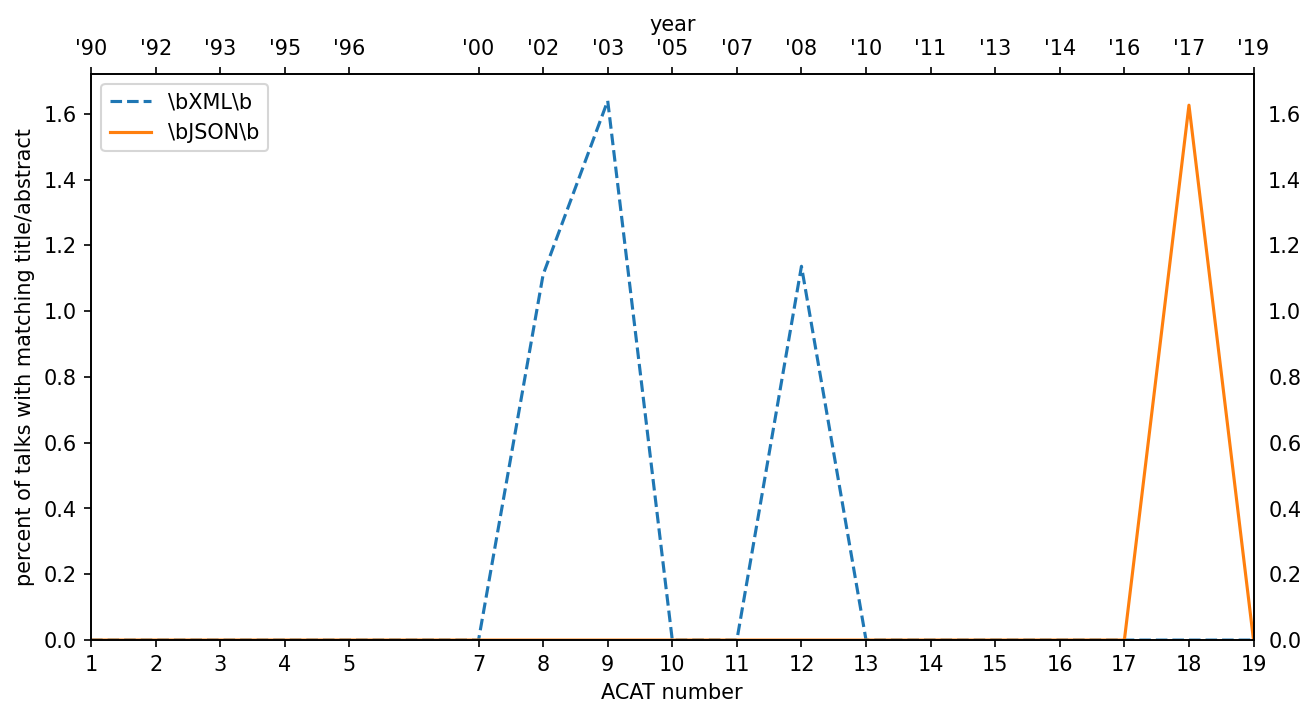

In [16]:
plot(words[32:34], counters, denoms, style=["--", "-"])
plt.savefig("PLOTS/acat-papers-textformat.svg")
plt.savefig("PLOTS/acat-papers-textformat.pdf")

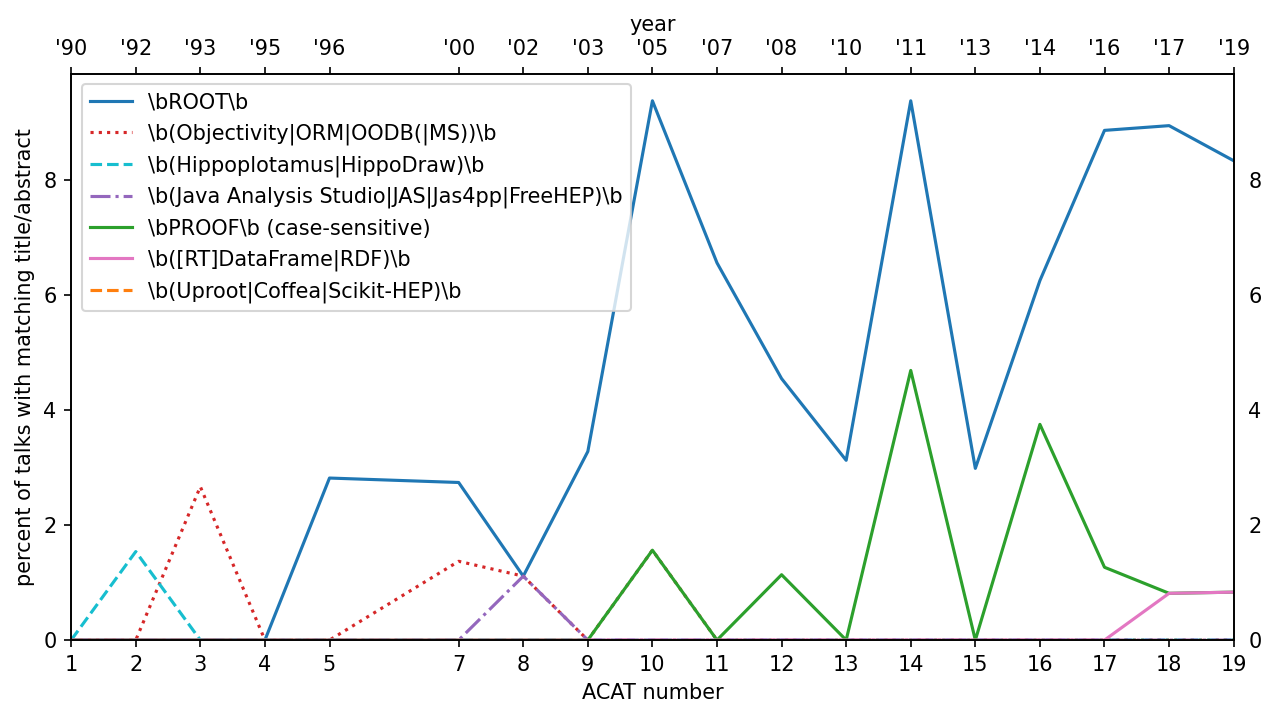

In [17]:
plot(words[34:41], counters, denoms, style=["-", ":", "--", "-.", "-", "-", "--"], color=[c1, c4, c10, c5, c3, c7, c2])
plt.savefig("PLOTS/acat-papers-package.svg")
plt.savefig("PLOTS/acat-papers-package.pdf")

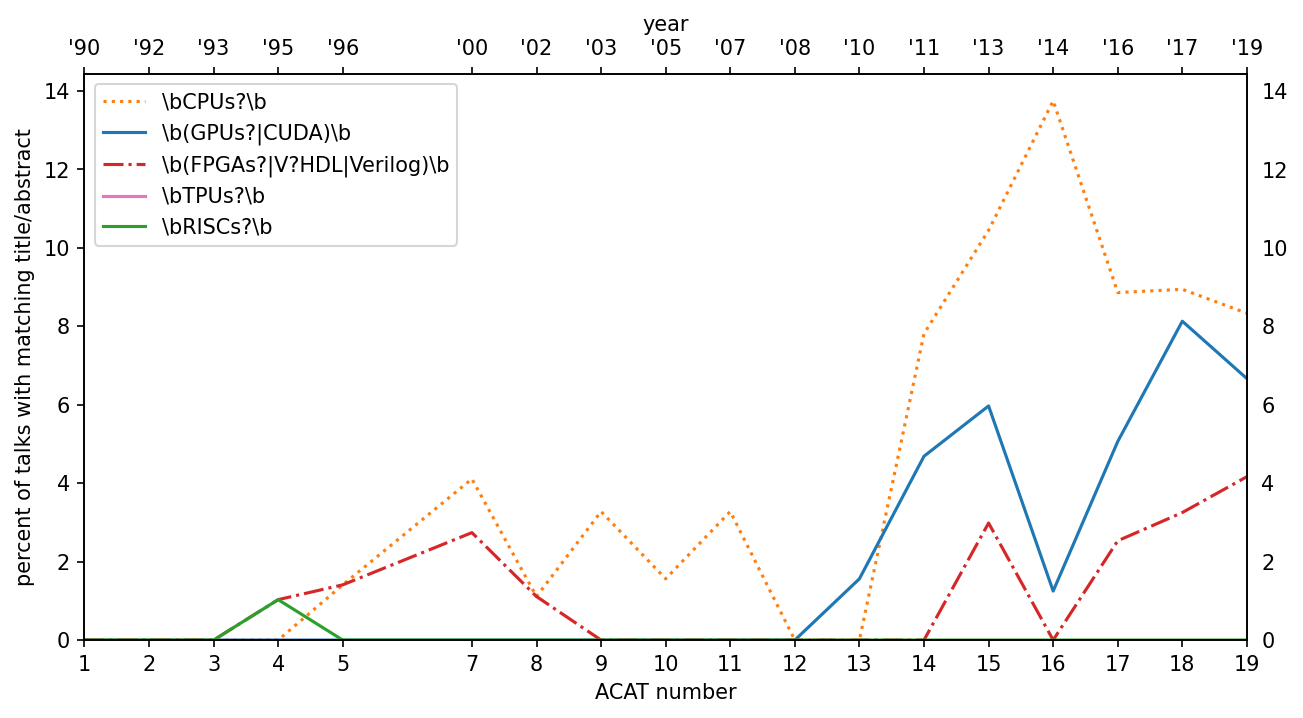

In [18]:
plot(words[41:46], counters, denoms, style=[":", "-", "-.", "-", "-"], color=[c2, c1, c4, c7, c3])
plt.savefig("PLOTS/acat-papers-accelerator.svg")
plt.savefig("PLOTS/acat-papers-accelerator.pdf")

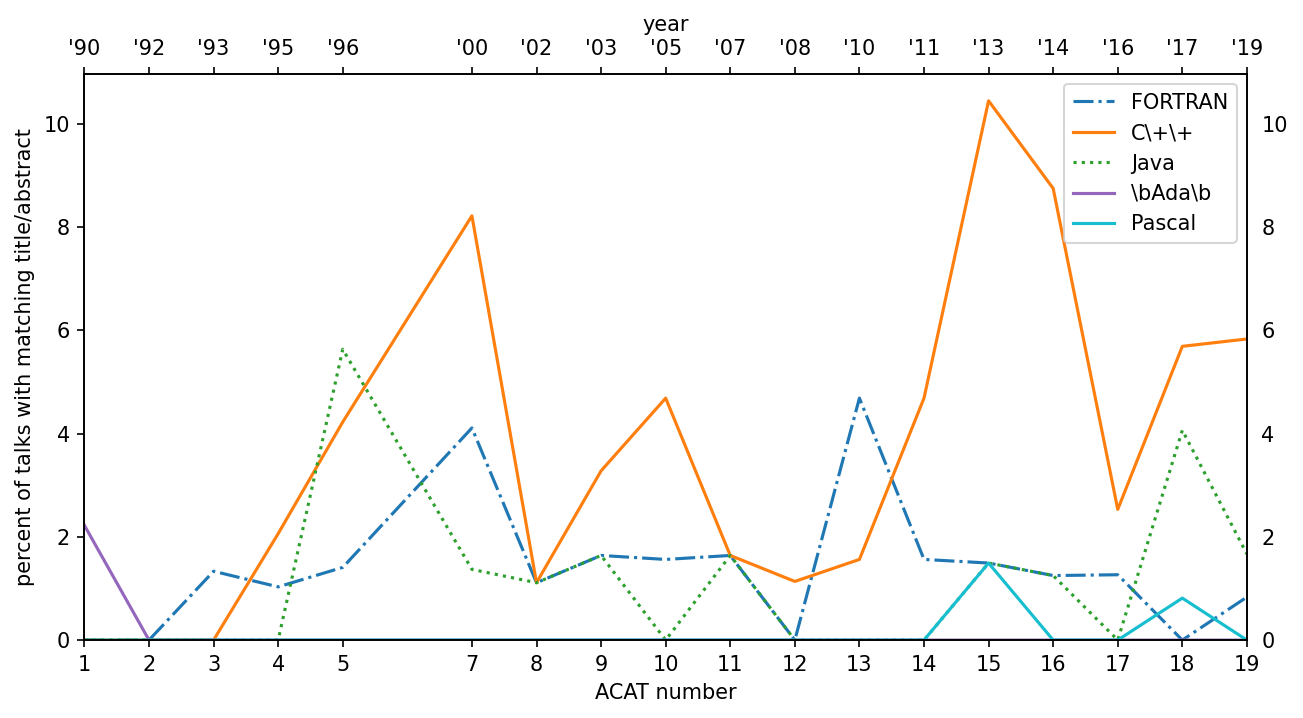

In [19]:
plot(words[19:22] + words[23:25], counters, denoms, style=["-.", "-", ":", "-", "-"], color=[c1, c2, c3, c5, c10, c4])
plt.savefig("PLOTS/acat-papers-language-1.svg")
plt.savefig("PLOTS/acat-papers-language-1.pdf")

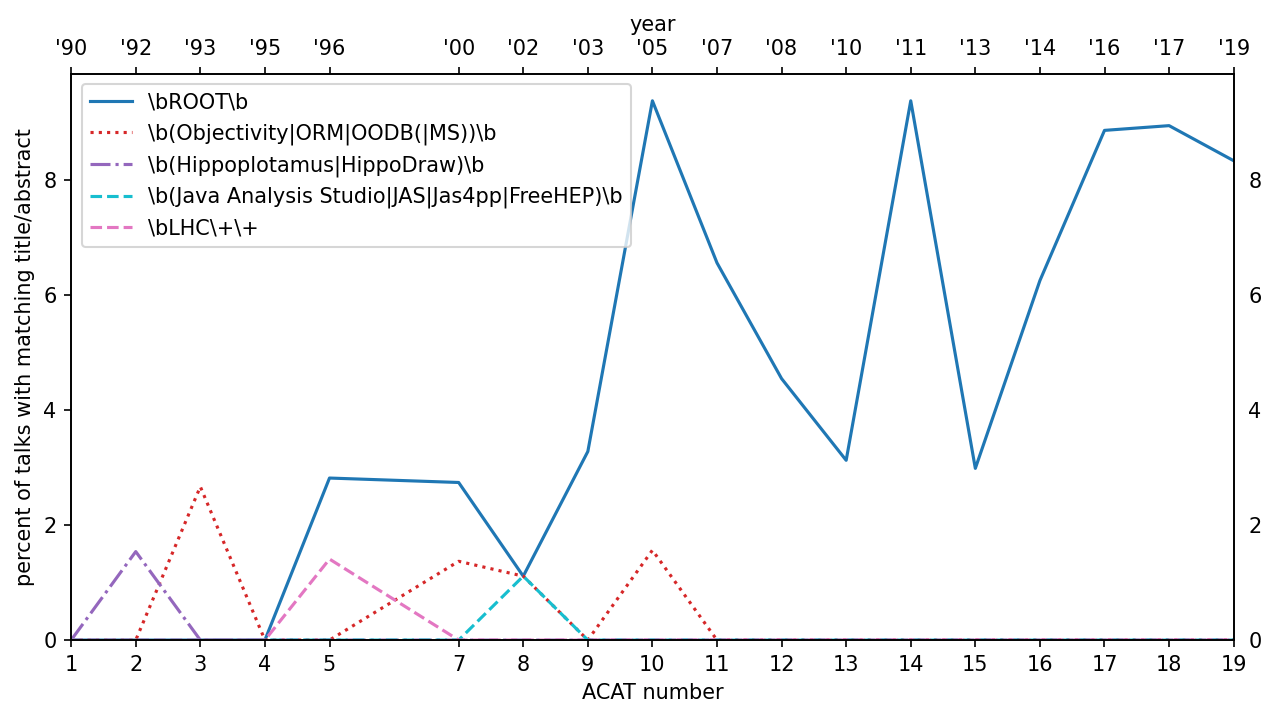

In [20]:
plot([words[34], words[35], words[37], words[36], words[-2]], counters, denoms, style=["-", ":", "-.", "--", "--"], color=[c1, c4, c5, c10, c7])
plt.savefig("PLOTS/acat-papers-package-1.svg")
plt.savefig("PLOTS/acat-papers-package-1.pdf")

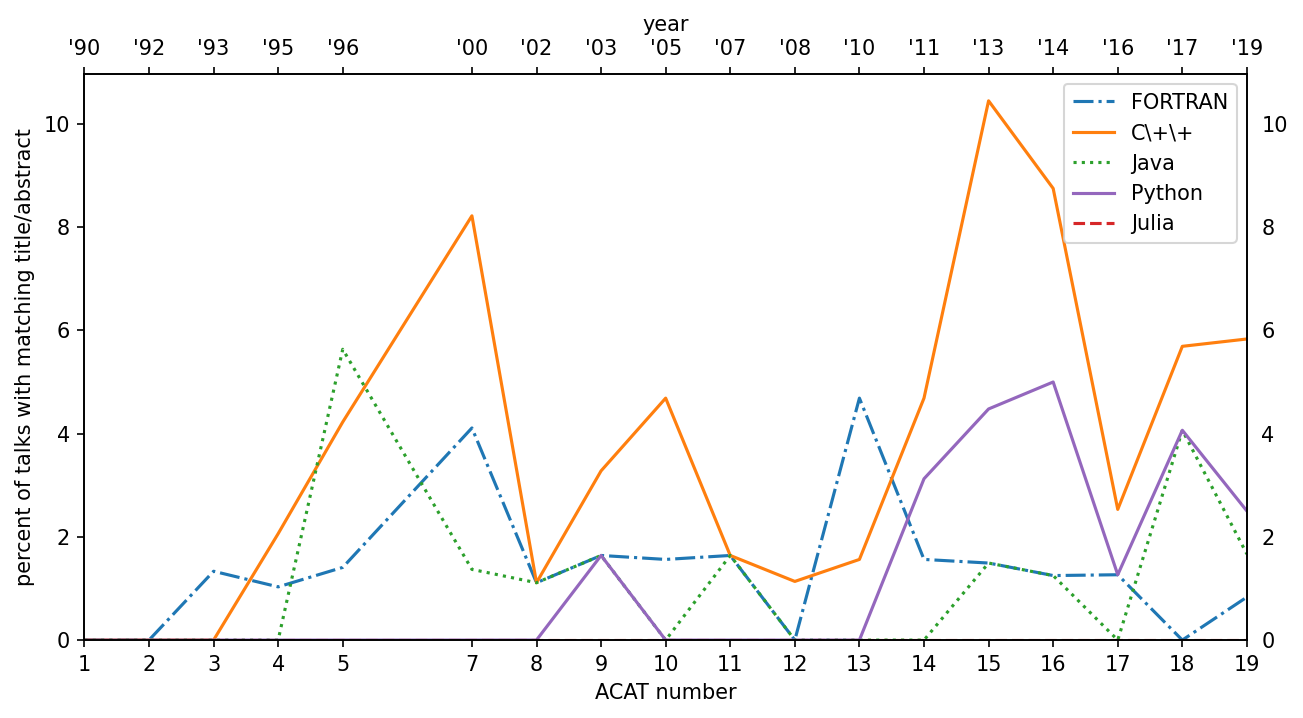

In [21]:
plot(words[19:23] + words[-1:], counters, denoms, style=["-.", "-", ":", "-", "--"], color=[c1, c2, c3, c5, c4])
plt.savefig("PLOTS/acat-papers-language-2.svg")
plt.savefig("PLOTS/acat-papers-language-2.pdf")

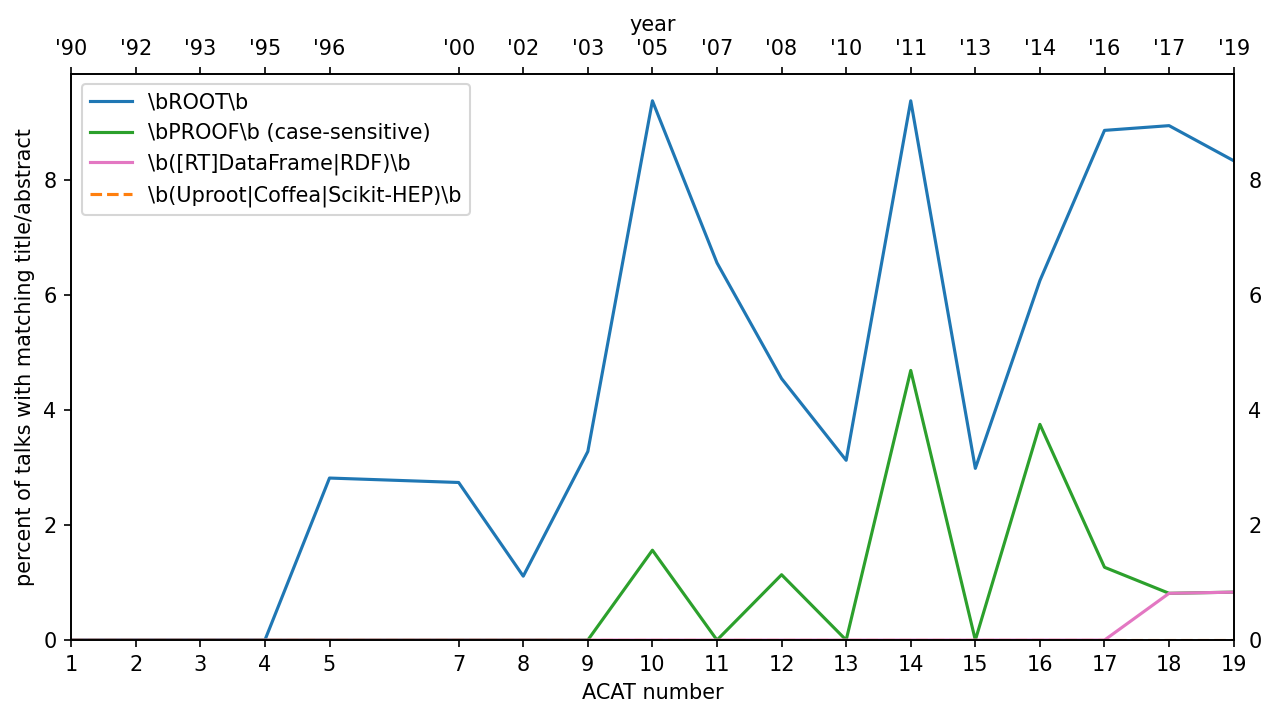

In [22]:
plot([words[34], words[38], words[39], words[40]], counters, denoms, style=["-", "-", "-", "--"], color=[c1, c3, c7, c2])
plt.savefig("PLOTS/acat-papers-package-2.svg")
plt.savefig("PLOTS/acat-papers-package-2.pdf")